In [1]:
import torch
import pyqtorch.modules as pyq


def HEA(n_qubits, n_layers):
    ops = []
    for _ in range(n_layers):
        ops.append(pyq.VariationalLayer(n_qubits, pyq.RX))
        ops.append(pyq.VariationalLayer(n_qubits, pyq.RY))
        ops.append(pyq.VariationalLayer(n_qubits, pyq.RX))
        ops.append(pyq.EntanglingLayer(n_qubits))
    return pyq.QuantumCircuit(n_qubits, ops)


def ULayerAnsatz(n_qubits, n_layers):
    ops = []
    for _ in range(n_layers):
        ops.append(pyq.VariationalLayer(n_qubits, pyq.U))
        ops.append(pyq.EntanglingLayer(n_qubits))
    return pyq.QuantumCircuit(n_qubits, ops)


class Model(torch.nn.Module):

    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.ansatz1 = ULayerAnsatz(n_qubits, n_layers)
        self.embedding = pyq.FeaturemapLayer(n_qubits, pyq.RX)
        self.ansatz2 = ULayerAnsatz(n_qubits, n_layers)
        self.observable = pyq.Z([0], n_qubits)
        
    def forward(self, x):
        batch_size = len(x)
        state = self.ansatz1.init_state(batch_size)
        
        state = self.ansatz1(state)
        state = self.embedding(state, x)
        state = self.ansatz2(state)
        
        new_state = self.observable(state)
        
        state = state.reshape((2**self.n_qubits, batch_size))
        new_state = new_state.reshape((2**self.n_qubits, batch_size))
        return torch.real(torch.sum(torch.conj(state) * new_state, axis=0))

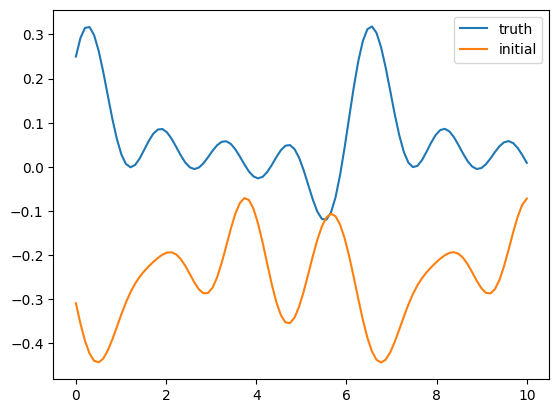

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def target_function(x, degree=3):
    result = 0
    for i in range(degree):
        result += torch.cos(i*x) + torch.sin(i*x)
    return .05 * result

x = torch.tensor(np.linspace(0, 10, 100))
target_y = target_function(x, 5)

n_qubits = 5
n_layers = 3
model = Model(n_qubits, n_layers)

with torch.no_grad():
    y = model(x)

plt.plot(x.numpy(), target_y.numpy(), label="truth")
plt.plot(x.numpy(), y.numpy(), label="initial")
plt.legend()

In [3]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=.01)
epochs = 200

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = F.mse_loss(target_y, y_pred)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss {loss}")

Epoch 1 | Loss 0.13427584409520107
Epoch 2 | Loss 0.11162884659683119
Epoch 3 | Loss 0.09079263388848328
Epoch 4 | Loss 0.07253752969369756
Epoch 5 | Loss 0.05724934605506702
Epoch 6 | Loss 0.04498449915054189
Epoch 7 | Loss 0.03555157808553377
Epoch 8 | Loss 0.02858461680428321
Epoch 9 | Loss 0.023627173939639007
Epoch 10 | Loss 0.020209824921552134
Epoch 11 | Loss 0.01790673729556685
Epoch 12 | Loss 0.016364802999390343
Epoch 13 | Loss 0.015311355367848903
Epoch 14 | Loss 0.014548423481347484
Epoch 15 | Loss 0.013940635406273163
Epoch 16 | Loss 0.013401244867599265
Epoch 17 | Loss 0.012878555883219131
Epoch 18 | Loss 0.012344730384730553
Epoch 19 | Loss 0.011787349638657393
Epoch 20 | Loss 0.011203672339103389
Epoch 21 | Loss 0.010596871532620162
Epoch 22 | Loss 0.009973530381214329
Epoch 23 | Loss 0.00934191865665746
Epoch 24 | Loss 0.008710812001528049
Epoch 25 | Loss 0.008088738518219044
Epoch 26 | Loss 0.00748350990127222
Epoch 27 | Loss 0.006902189546819951
Epoch 28 | Loss 0.006

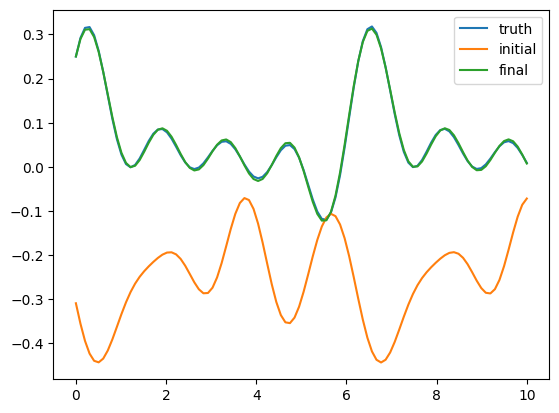

In [4]:
with torch.no_grad():
    y_final = model(x)

plt.plot(x.numpy(), target_y.numpy(), label="truth")
plt.plot(x.numpy(), y.numpy(), label="initial")
plt.plot(x.numpy(), y_final.numpy(), label="final")
plt.legend()